Use an image and reconstruct the image in the following two cases, where your region is-

1. rectangular block of 30X30 is assumed missing from the image.
2. random subset of 900 (30X30) pixels is missing from the image.

Choose rank r yourself. Perform Gradient Descent till convergence, plot the selected regions, original and reconstructed images, Compute the following metrics:



*   RMSE on predicted v/s ground truth high resolution image
*   Peak SNR



Loading the image and cropping


Original image shape: (500, 750, 3)


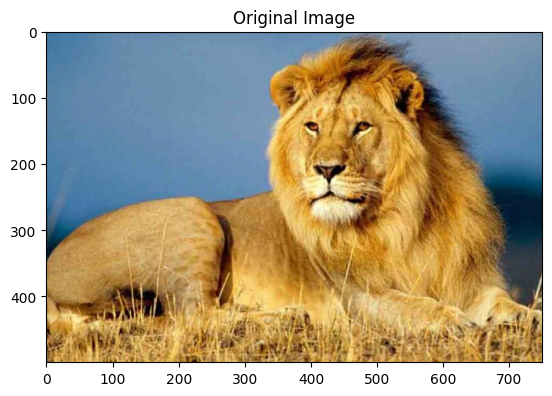

Cropped image shape: (440, 300, 3)


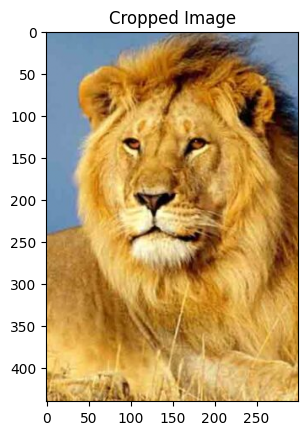

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
import requests
from io import BytesIO

# Load the color image
response = requests.get("https://safariavventura.com/wp-content/uploads/2018/02/leone-africano-2-750x500.jpg")
img = Image.open(BytesIO(response.content)).convert('RGB')
img = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
print(f"Original image shape: {img.shape}")

# Display the original image
plt.imshow(img)
plt.title("Original Image")
plt.axis('on')
plt.show()

# Crop the image with valid coordinates
# Ensure the cropping coordinates are within the image dimensions
left, upper, right, lower = 300, 10, 600, 450   # Adjust these coordinates for a larger crop
right = min(right, img.shape[1])  # Ensure the crop doesn't go out of bounds
lower = min(lower, img.shape[0])  # Ensure the crop doesn't go out of bounds

cropped_img = Image.fromarray((img * 255).astype(np.uint8)).crop((left, upper, right, lower))
cropped_img = np.array(cropped_img) / 255.0  # Normalize again after cropping
print(f"Cropped image shape: {cropped_img.shape}")

# Display the cropped image
plt.imshow(cropped_img)
plt.title("Cropped Image")
plt.axis('on')
plt.show()

Masking the image with rectangular patch



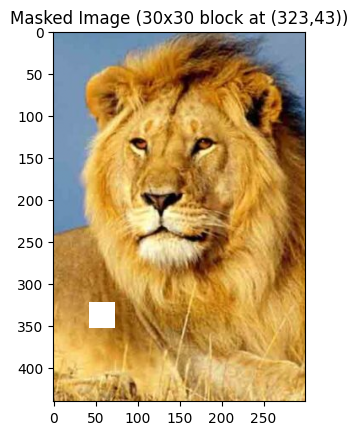

In [27]:
def mask_image_with_block(image, block_size=30):
    masked_image = image.copy()
    m, n, c = masked_image.shape

    # Randomly choose top-left corner of the block
    top = np.random.randint(0, m - block_size)
    left = np.random.randint(0, n - block_size)

    # Mask the rectangular block
    masked_image[top:top + block_size, left:left + block_size, :] = np.nan

    # Create a binary mask (True where missing)
    mask = np.zeros((m, n), dtype=bool)
    mask[top:top + block_size, left:left + block_size] = True

    return masked_image, mask, (top, left)

# Example usage
masked_block_img, block_mask, (top, left) = mask_image_with_block(cropped_img)

# Display
plt.imshow(masked_block_img)
plt.title(f"Masked Image (30x30 block at ({top},{left}))")
plt.axis('on')
plt.show()

Reconstuncting only the rectangular Patch

Using Gradient Decent

In [67]:
def matrix_factorization_with_mask_color(R, mask, r, lr=0.005, epochs=1000):
    m, n, c = R.shape
    W_list = []
    H_list = []
    loss_history = []

    for channel in range(c):
        R_channel = R[:, :, channel]
        mask_channel = mask

        # Initialize matrices
        W = torch.randn(m, r, requires_grad=True, device=device)
        H = torch.randn(r, n, requires_grad=True, device=device)

        optimizer = torch.optim.Adam([W, H], lr=lr)

        # Replace NaN values with 0 for computation, but use the mask to ignore them in loss
        R_tensor = torch.tensor(np.nan_to_num(R_channel), dtype=torch.float32, device=device)
        mask_tensor = torch.tensor(~mask_channel, dtype=torch.float32, device=device)  # Invert mask to use as weights (1 for known pixels)

        for epoch in range(epochs):
            optimizer.zero_grad()
            R_hat = torch.mm(W, H)
            # Calculate loss only over known pixels
            loss = torch.mean((R_hat * mask_tensor - R_tensor * mask_tensor) ** 2)  # Mean Squared Error
            loss.backward()
            optimizer.step()

            loss_history.append(loss.item())
            if epoch % 100 == 0:
                print(f"Channel {channel}, Epoch {epoch}/{epochs}, Loss: {loss.item()}")

        W_list.append(W)
        H_list.append(H)

    return W_list, H_list, loss_history

# Ensure device is set (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Apply matrix factorization for each channel
r = 60  # Adjust this value as necessary
W_list, H_list, loss_history = matrix_factorization_with_mask_color(masked_block_img, block_mask, r, lr=0.01, epochs=2000)

Channel 0, Epoch 0/2000, Loss: 60.94225311279297
Channel 0, Epoch 100/2000, Loss: 3.193014621734619
Channel 0, Epoch 200/2000, Loss: 0.23217655718326569
Channel 0, Epoch 300/2000, Loss: 0.042279068380594254
Channel 0, Epoch 400/2000, Loss: 0.023940352723002434
Channel 0, Epoch 500/2000, Loss: 0.02003866620361805
Channel 0, Epoch 600/2000, Loss: 0.017641622573137283
Channel 0, Epoch 700/2000, Loss: 0.01545417495071888
Channel 0, Epoch 800/2000, Loss: 0.014009249396622181
Channel 0, Epoch 900/2000, Loss: 0.013138174079358578
Channel 0, Epoch 1000/2000, Loss: 0.01243702694773674
Channel 0, Epoch 1100/2000, Loss: 0.011722969822585583
Channel 0, Epoch 1200/2000, Loss: 0.010972951538860798
Channel 0, Epoch 1300/2000, Loss: 0.010235907509922981
Channel 0, Epoch 1400/2000, Loss: 0.00956335011869669
Channel 0, Epoch 1500/2000, Loss: 0.00897823367267847
Channel 0, Epoch 1600/2000, Loss: 0.008479529060423374
Channel 0, Epoch 1700/2000, Loss: 0.008055349811911583
Channel 0, Epoch 1800/2000, Loss: 

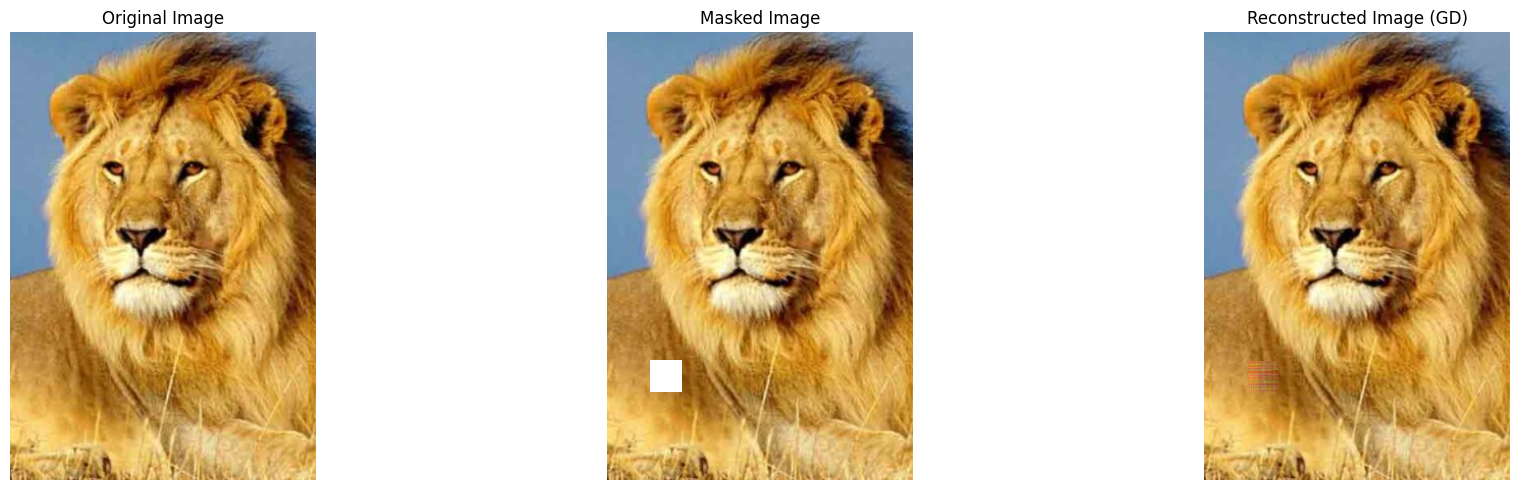

In [68]:
# Reconstruct full image
reconstructed_img = np.zeros_like(cropped_img)

for channel in range(cropped_img.shape[2]):
    W = W_list[channel]
    H = H_list[channel]
    reconstructed_channel = torch.mm(W, H).detach().cpu().numpy()
    reconstructed_img[:, :, channel] = reconstructed_channel

# Fill missing pixels
reconstructed_img_with_missing = masked_block_img.copy()

for channel in range(cropped_img.shape[2]):
    nan_mask = np.isnan(masked_block_img[:, :, channel])
    reconstructed_img_with_missing[:, :, channel][nan_mask] = reconstructed_img[:, :, channel][nan_mask]

# Clip values between 0 and 1
reconstructed_img_with_missing = np.clip(reconstructed_img_with_missing, 0, 1)
reconstructed_img = np.clip(reconstructed_img, 0, 1)

# Display side-by-side: Original, Masked, Mask Region, Reconstructed
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].imshow(cropped_img)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(masked_block_img)
ax[1].set_title("Masked Image")
ax[1].axis("off")

ax[2].imshow(reconstructed_img_with_missing)
ax[2].set_title("Reconstructed Image (GD)")
ax[2].axis("off")

plt.tight_layout()
plt.show()


RMSE and PNR

In [69]:
import numpy as np

def compute_metrics(original, reconstructed):
    # Ensure arrays are float32
    original = original.astype(np.float32)
    reconstructed = reconstructed.astype(np.float32)

    # Compute RMSE
    mse = np.mean((original - reconstructed) ** 2)
    rmse = np.sqrt(mse)

    # Compute PSNR
    if mse == 0:
        psnr = float('inf')
    else:
        psnr = 20 * np.log10(1.0 / np.sqrt(mse))  # since images are normalized in [0,1]

    return rmse, psnr


# Example usage
rmse, psnr = compute_metrics(cropped_img, reconstructed_img_with_missing)

print(f"RMSE: {rmse:.6f}")
print(f"PSNR: {psnr:.2f} dB")


RMSE: 0.007921
PSNR: 42.02 dB


USING ALS method

In [32]:
import torch
import numpy as np

def matrix_factorization_als_color(R, mask, r, max_iters=100, device="cpu"):
    m, n, c = R.shape
    W_list, H_list = [], []
    torch.manual_seed(0)
    init_W = torch.randn(m, r, device=device)
    init_H = torch.randn(r, n, device=device)

    for channel in range(c):
        W = init_W.clone()
        H = init_H.clone()

        R_channel = R[:, :, channel]
        mask_channel = mask

        # Replace NaN with 0 for computation
        R_tensor = torch.tensor(np.nan_to_num(R_channel), dtype=torch.float32, device=device)
        mask_tensor = torch.tensor(~mask_channel, dtype=torch.float32, device=device)

        # Initialize factors
        W = torch.randn(m, r, device=device)
        H = torch.randn(r, n, device=device)

        for iter in range(max_iters):
            # --- Update W ---
            for i in range(m):
                known_idx = mask_tensor[i, :] == 1
                if known_idx.sum() == 0:
                    continue
                H_sub = H[:, known_idx]
                R_sub = R_tensor[i, known_idx]
                sol = torch.linalg.lstsq(H_sub.T, R_sub)
                W[i, :] = sol.solution

            # --- Update H ---
            for j in range(n):
                known_idx = mask_tensor[:, j] == 1
                if known_idx.sum() == 0:
                    continue
                W_sub = W[known_idx, :]
                R_sub = R_tensor[known_idx, j]
                sol = torch.linalg.lstsq(W_sub, R_sub)
                H[:, j] = sol.solution

            # Compute loss (for monitoring)
            R_hat = torch.mm(W, H)
            loss = torch.sum(((R_hat - R_tensor) * mask_tensor) ** 2) / mask_tensor.sum()
            if iter % 10 == 0:
                print(f"Channel {channel}, Iter {iter}/{max_iters}, Loss: {loss.item():.6f}")

        W_list.append(W)
        H_list.append(H)

    return W_list, H_list


Channel 0, Iter 0/50, Loss: 0.005898
Channel 0, Iter 10/50, Loss: 0.002296
Channel 0, Iter 20/50, Loss: 0.002284
Channel 0, Iter 30/50, Loss: 0.002274
Channel 0, Iter 40/50, Loss: 0.002273
Channel 1, Iter 0/50, Loss: 0.005889
Channel 1, Iter 10/50, Loss: 0.002293
Channel 1, Iter 20/50, Loss: 0.002291
Channel 1, Iter 30/50, Loss: 0.002291
Channel 1, Iter 40/50, Loss: 0.002291
Channel 2, Iter 0/50, Loss: 0.005248
Channel 2, Iter 10/50, Loss: 0.002097
Channel 2, Iter 20/50, Loss: 0.002095
Channel 2, Iter 30/50, Loss: 0.002095
Channel 2, Iter 40/50, Loss: 0.002095


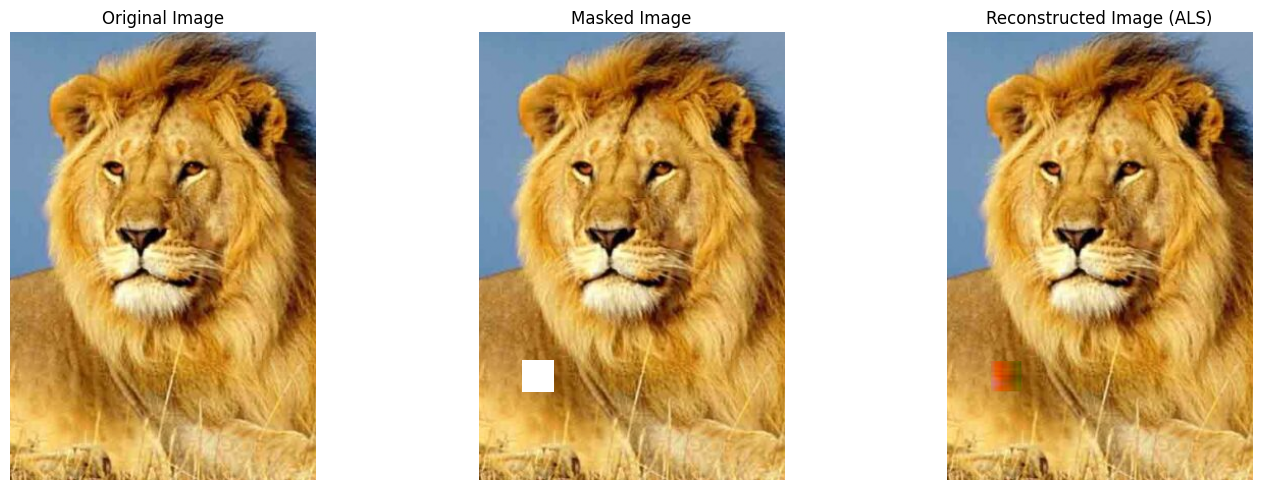

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Apply ALS matrix factorization
r = 20  # lower rank for stability
W_list, H_list = matrix_factorization_als_color(masked_block_img, block_mask, r, max_iters=50, device=device)

# Reconstruct image
reconstructed_img = np.zeros_like(cropped_img)
for channel in range(cropped_img.shape[2]):
    reconstructed_channel = torch.mm(W_list[channel], H_list[channel]).detach().cpu().numpy()
    reconstructed_img[:, :, channel] = reconstructed_channel

# Fill missing region
reconstructed_img_with_missing = masked_block_img.copy()
for channel in range(cropped_img.shape[2]):
    nan_mask = np.isnan(masked_block_img[:, :, channel])
    reconstructed_img_with_missing[:, :, channel][nan_mask] = reconstructed_img[:, :, channel][nan_mask]

# Clip
reconstructed_img_with_missing = np.clip(reconstructed_img_with_missing, 0, 1)

# Plot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(cropped_img)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(masked_block_img)
ax[1].set_title("Masked Image")
ax[1].axis("off")

ax[2].imshow(reconstructed_img_with_missing)
ax[2].set_title("Reconstructed Image (ALS)")
ax[2].axis("off")

plt.tight_layout()
plt.show()


In [71]:
rmse, psnr = compute_metrics(cropped_img, reconstructed_img_with_missing)

print(f"RMSE: {rmse:.6f}")
print(f"PSNR: {psnr:.2f} dB")

RMSE: 0.007921
PSNR: 42.02 dB


900 - MISSING PIXELS

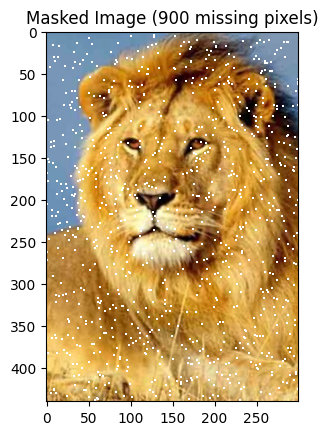

In [2]:
def mask_image_with_nan(image, num_missing=900):
    """
    Randomly mask a certain number of pixels in the image by setting them to NaN.
    """
    masked_image = image.copy()
    m, n, c = masked_image.shape
    total_pixels = m * n
    flat_indices = np.random.choice(total_pixels, num_missing, replace=False)
    mask = np.zeros((m, n), dtype=bool).reshape(-1)
    mask[flat_indices] = True
    mask = mask.reshape((m, n))
    masked_image[mask] = np.nan
    return masked_image, mask

masked_img, mask = mask_image_with_nan(cropped_img, 900)

# Display the masked image
plt.imshow(masked_img)
plt.title("Masked Image (900 missing pixels)")
plt.axis('on')
plt.show()

In [78]:
def matrix_factorization_with_mask_color(R, mask, r, lr=0.005, epochs=1000):
    """
    Perform matrix factorization on a color image with missing pixels using gradient descent.
    """
    m, n, c = R.shape
    W_list = []
    H_list = []
    loss_history = []

    for channel in range(c):
        R_channel = R[:, :, channel]
        mask_channel = mask

        # Initialize matrices
        W = torch.randn(m, r, requires_grad=True, device=device)
        H = torch.randn(r, n, requires_grad=True, device=device)

        optimizer = torch.optim.Adam([W, H], lr=lr)

        # Replace NaN values with 0 for computation, but use the mask to ignore them in loss
        R_tensor = torch.tensor(np.nan_to_num(R_channel), dtype=torch.float32, device=device)
        mask_tensor = torch.tensor(~mask_channel, dtype=torch.float32, device=device)  # Invert mask to use as weights (1 for known pixels)

        for epoch in range(epochs):
            optimizer.zero_grad()
            R_hat = torch.mm(W, H)
            # Calculate loss only over known pixels
            loss = torch.mean((R_hat * mask_tensor - R_tensor * mask_tensor) ** 2)  # Mean Squared Error
            loss.backward()
            optimizer.step()

            loss_history.append(loss.item())
            if epoch % 100 == 0:
                print(f"Channel {channel}, Epoch {epoch}/{epochs}, Loss: {loss.item()}")

        W_list.append(W)
        H_list.append(H)

    return W_list, H_list, loss_history

# Ensure device is set (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Apply matrix factorization for each channel
r = 200  # Adjust this value as necessary
W_list, H_list, loss_history = matrix_factorization_with_mask_color(masked_img, mask, r, lr=0.01, epochs=2000)

Channel 0, Epoch 0/2000, Loss: 201.48269653320312
Channel 0, Epoch 100/2000, Loss: 4.852995872497559
Channel 0, Epoch 200/2000, Loss: 0.27229681611061096
Channel 0, Epoch 300/2000, Loss: 0.046703629195690155
Channel 0, Epoch 400/2000, Loss: 0.01929786615073681
Channel 0, Epoch 500/2000, Loss: 0.013002637773752213
Channel 0, Epoch 600/2000, Loss: 0.010439836420118809
Channel 0, Epoch 700/2000, Loss: 0.008824381977319717
Channel 0, Epoch 800/2000, Loss: 0.007639426272362471
Channel 0, Epoch 900/2000, Loss: 0.006748974788933992
Channel 0, Epoch 1000/2000, Loss: 0.006050685420632362
Channel 0, Epoch 1100/2000, Loss: 0.005478911567479372
Channel 0, Epoch 1200/2000, Loss: 0.005011512897908688
Channel 0, Epoch 1300/2000, Loss: 0.00464008329436183
Channel 0, Epoch 1400/2000, Loss: 0.004348429385572672
Channel 0, Epoch 1500/2000, Loss: 0.00411505252122879
Channel 0, Epoch 1600/2000, Loss: 0.003919154405593872
Channel 0, Epoch 1700/2000, Loss: 0.0037444124463945627
Channel 0, Epoch 1800/2000, Lo

Reconstructing only missing pixels


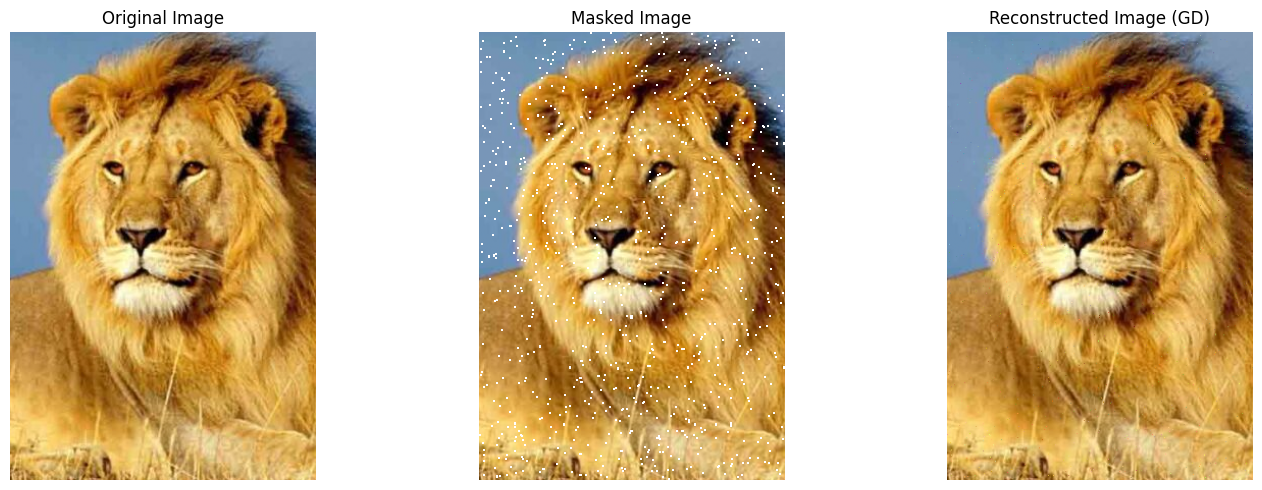

In [79]:
# Reconstruct full image from W_list and H_list
reconstructed_img = np.zeros_like(cropped_img)

for channel in range(cropped_img.shape[2]):
    W = W_list[channel]
    H = H_list[channel]
    reconstructed_channel = torch.mm(W, H).detach().cpu().numpy()
    reconstructed_img[:, :, channel] = reconstructed_channel

# Fill missing pixels in masked image using reconstructed values
reconstructed_img_with_missing = masked_img.copy()

for channel in range(cropped_img.shape[2]):
    nan_mask = np.isnan(masked_img[:, :, channel])
    reconstructed_img_with_missing[:, :, channel][nan_mask] = reconstructed_img[:, :, channel][nan_mask]

# Clip values between 0 and 1 (to avoid color overflow)
reconstructed_img_with_missing = np.clip(reconstructed_img_with_missing, 0, 1)
reconstructed_img = np.clip(reconstructed_img, 0, 1)

# Display side-by-side: Original, Masked, Reconstructed
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(cropped_img)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(masked_img)
ax[1].set_title("Masked Image")
ax[1].axis("off")

ax[2].imshow(reconstructed_img_with_missing)
ax[2].set_title("Reconstructed Image (GD)")
ax[2].axis("off")

plt.tight_layout()
plt.show()


In [80]:
import numpy as np

def compute_metrics(original, reconstructed):
    # Ensure arrays are float32
    original = original.astype(np.float32)
    reconstructed = reconstructed.astype(np.float32)

    # Compute RMSE
    mse = np.mean((original - reconstructed) ** 2)
    rmse = np.sqrt(mse)

    # Compute PSNR
    if mse == 0:
        psnr = float('inf')
    else:
        psnr = 20 * np.log10(1.0 / np.sqrt(mse))  # since images are normalized in [0,1]

    return rmse, psnr


# Example usage
rmse, psnr = compute_metrics(cropped_img, reconstructed_img_with_missing)

print(f"RMSE: {rmse:.6f}")
print(f"PSNR: {psnr:.2f} dB")


RMSE: 0.009088
PSNR: 40.83 dB


In [4]:
import torch
import numpy as np

def matrix_factorization_als_color(R, mask, r, max_iters=100, device="cpu"):
    m, n, c = R.shape
    W_list, H_list = [], []
    torch.manual_seed(0)
    init_W = torch.randn(m, r, device=device)
    init_H = torch.randn(r, n, device=device)

    for channel in range(c):
        W = init_W.clone()
        H = init_H.clone()

        R_channel = R[:, :, channel]
        mask_channel = mask

        # Replace NaN with 0 for computation
        R_tensor = torch.tensor(np.nan_to_num(R_channel), dtype=torch.float32, device=device)
        mask_tensor = torch.tensor(~mask_channel, dtype=torch.float32, device=device)

        # Initialize factors
        W = torch.randn(m, r, device=device)
        H = torch.randn(r, n, device=device)

        for iter in range(max_iters):
            # --- Update W ---
            for i in range(m):
                known_idx = mask_tensor[i, :] == 1
                if known_idx.sum() == 0:
                    continue
                H_sub = H[:, known_idx]
                R_sub = R_tensor[i, known_idx]
                sol = torch.linalg.lstsq(H_sub.T, R_sub)
                W[i, :] = sol.solution

            # --- Update H ---
            for j in range(n):
                known_idx = mask_tensor[:, j] == 1
                if known_idx.sum() == 0:
                    continue
                W_sub = W[known_idx, :]
                R_sub = R_tensor[known_idx, j]
                sol = torch.linalg.lstsq(W_sub, R_sub)
                H[:, j] = sol.solution

            # Compute loss (for monitoring)
            R_hat = torch.mm(W, H)
            loss = torch.sum(((R_hat - R_tensor) * mask_tensor) ** 2) / mask_tensor.sum()
            if iter % 10 == 0:
                print(f"Channel {channel}, Iter {iter}/{max_iters}, Loss: {loss.item():.6f}")

        W_list.append(W)
        H_list.append(H)

    return W_list, H_list


Channel 0, Iter 0/50, Loss: 0.008155
Channel 0, Iter 10/50, Loss: 0.002283
Channel 0, Iter 20/50, Loss: 0.002279
Channel 0, Iter 30/50, Loss: 0.002279
Channel 0, Iter 40/50, Loss: 0.002279
Channel 1, Iter 0/50, Loss: 0.007611
Channel 1, Iter 10/50, Loss: 0.002294
Channel 1, Iter 20/50, Loss: 0.002294
Channel 1, Iter 30/50, Loss: 0.002294
Channel 1, Iter 40/50, Loss: 0.002294
Channel 2, Iter 0/50, Loss: 0.006082
Channel 2, Iter 10/50, Loss: 0.002114
Channel 2, Iter 20/50, Loss: 0.002110
Channel 2, Iter 30/50, Loss: 0.002109
Channel 2, Iter 40/50, Loss: 0.002109


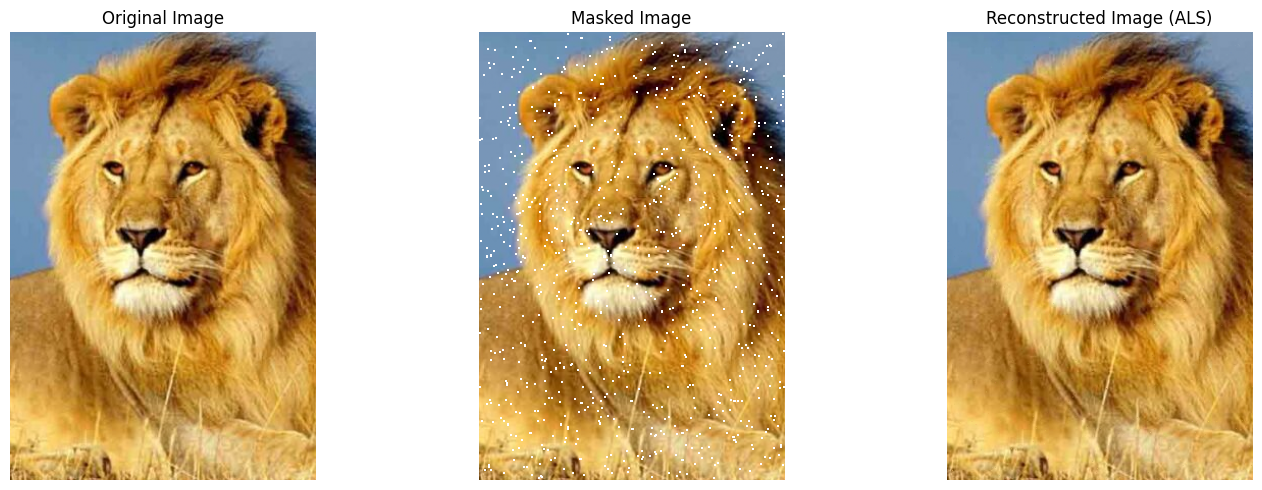

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Apply ALS matrix factorization
r = 20  # lower rank for stability
W_list, H_list = matrix_factorization_als_color(masked_img, mask, r, max_iters=50, device=device)

# Reconstruct image
reconstructed_img = np.zeros_like(cropped_img)
for channel in range(cropped_img.shape[2]):
    reconstructed_channel = torch.mm(W_list[channel], H_list[channel]).detach().cpu().numpy()
    reconstructed_img[:, :, channel] = reconstructed_channel

# Fill missing region
reconstructed_img_with_missing = masked_img.copy()
for channel in range(cropped_img.shape[2]):
    nan_mask = np.isnan(masked_img[:, :, channel])
    reconstructed_img_with_missing[:, :, channel][nan_mask] = reconstructed_img[:, :, channel][nan_mask]

# Clip
reconstructed_img_with_missing = np.clip(reconstructed_img_with_missing, 0, 1)

# Plot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(cropped_img)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(masked_img)
ax[1].set_title("Masked Image")
ax[1].axis("off")

ax[2].imshow(reconstructed_img_with_missing)
ax[2].set_title("Reconstructed Image (ALS)")
ax[2].axis("off")

plt.tight_layout()
plt.show()

In [8]:
import numpy as np

def compute_metrics(original, reconstructed):
    # Ensure arrays are float32
    original = original.astype(np.float32)
    reconstructed = reconstructed.astype(np.float32)

    # Compute RMSE
    mse = np.mean((original - reconstructed) ** 2)
    rmse = np.sqrt(mse)

    # Compute PSNR
    if mse == 0:
        psnr = float('inf')
    else:
        psnr = 20 * np.log10(1.0 / np.sqrt(mse))  # since images are normalized in [0,1]

    return rmse, psnr


# Example usage
rmse, psnr = compute_metrics(cropped_img, reconstructed_img_with_missing)

print(f"RMSE: {rmse:.6f}")
print(f"PSNR: {psnr:.2f} dB")


RMSE: 0.004556
PSNR: 46.83 dB


Consider an image patch of size (NxN) where N=50. We are trying to compress this patch (matrix) into two matrices, by using low-rank matrix factorization. Consider the following three cases-



a patch with at least 5 different colors.

1. a patch with mainly a single color.
2. a patch with 2-3 different colors.
3. a patch with at least 5 different colors.


Vary the low-rank value as r = [5, 10, 25, 50] for each of the cases. Use Gradient Descent and plot the reconstructed patches over the original image (retaining all pixel values outside the patch, and using your learnt compressed matrix in place of the patch) to demonstrate difference in reconstruction quality. Write your observations.

In [44]:
def extract_patch(img, top, left, size=50):
    return img[top:top+size, left:left+size, :]

def replace_patch(img, patch, top, left):
    out = img.copy()
    h,w,_ = patch.shape
    out[top:top+h, left:left+w, :] = patch
    return out

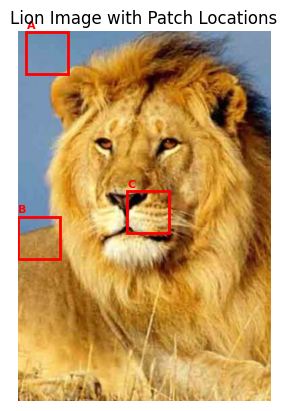

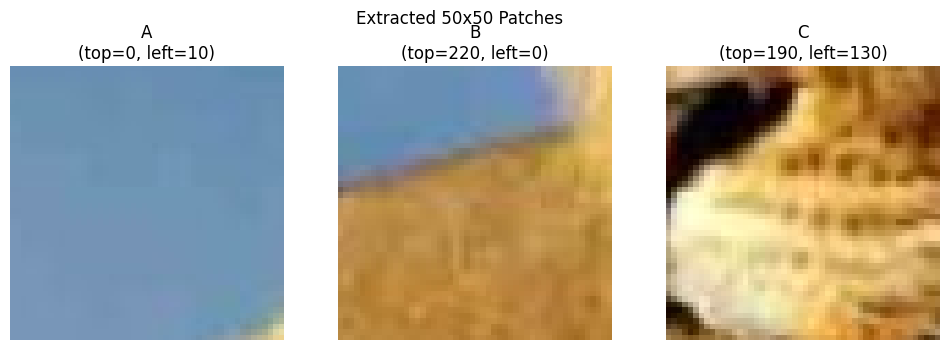

In [85]:
import matplotlib.patches as patches
patch_coords = {
    'A': (0, 10),
    'B': (220, 00),
    'C': (190, 130),
}
size = 50

# Extracting patches
def extract_patch(img, top, left, size=50):
    return img[top:top+size, left:left+size, :]

fig, ax = plt.subplots()
ax.imshow(cropped_img)
ax.set_title("Lion Image with Patch Locations")

# Add red rectangles for each patch
for name, (top, left) in patch_coords.items():
    rect = patches.Rectangle((left, top), size, size, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(left, top-5, name, color='red', fontsize=8, weight='bold')

plt.axis('off')
plt.show()

# Show patches
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, (name, (top, left)) in enumerate(patch_coords.items()):
    patch = extract_patch(cropped_img, top, left, size)
    axes[i].imshow(patch)
    axes[i].set_title(f"{name}\n(top={top}, left={left})")
    axes[i].axis('off')
plt.suptitle("Extracted 50x50 Patches")
plt.show()

In [83]:
def rmse(gt, recon):
    return np.sqrt(np.mean((gt - recon)**2))

def psnr(gt, recon, maxval=1.0):
    mse = np.mean((gt - recon)**2)
    if mse == 0: return float('inf')
    return 20*np.log10(maxval) - 10*np.log10(mse)

In [84]:
def gd_mf_channel(patch_channel, r=10, lr=0.05, epochs=500, device='cpu'):
    m,n = patch_channel.shape
    # convert to torch
    X = torch.tensor(patch_channel, dtype=torch.float32, device=device)
    W = torch.randn(m, r, device=device, requires_grad=True)
    H = torch.randn(r, n, device=device, requires_grad=True)
    opt = torch.optim.Adam([W, H], lr=lr)
    for e in range(epochs):
        opt.zero_grad()
        Xhat = W @ H
        loss = torch.mean((Xhat - X)**2)
        loss.backward()
        opt.step()
        # optional: decay lr or early stop
    return (W.detach().cpu().numpy() @ H.detach().cpu().numpy()).clip(0,1)

def gd_mf_patch(patch, r=10, lr=0.05, epochs=500, device='cpu'):
    out = np.zeros_like(patch)
    for c in range(3):
        out[:,:,c] = gd_mf_channel(patch[:,:,c], r=r, lr=lr, epochs=epochs, device=device)
    return out

In [89]:
results = {}  # store results as {(patch_name, r): (rmse, psnr, full_img)}

r_values = [5, 10, 25, 50]

for name, (top, left) in patch_coords.items():
    patch = extract_patch(cropped_img, top, left, size)
    print(f"\nProcessing patch: {name}")

    for r in r_values:
        print(f"  -> Rank r = {r}")

        # Reconstruct using GD-based Matrix Factorization
        recon_patch = gd_mf_patch(patch, r=r, lr=0.01, epochs=1000, device='cpu')

        # Replace reconstructed patch into full image
        full_img = replace_patch(cropped_img, recon_patch, top, left)

        # Compute metrics
        rm = rmse(patch, recon_patch)
        ps = psnr(patch, recon_patch)

        # Store results
        results[(name, r)] = (rm, ps, full_img)


Processing patch: A
  -> Rank r = 5
  -> Rank r = 10
  -> Rank r = 25
  -> Rank r = 50

Processing patch: B
  -> Rank r = 5
  -> Rank r = 10
  -> Rank r = 25
  -> Rank r = 50

Processing patch: C
  -> Rank r = 5
  -> Rank r = 10
  -> Rank r = 25
  -> Rank r = 50


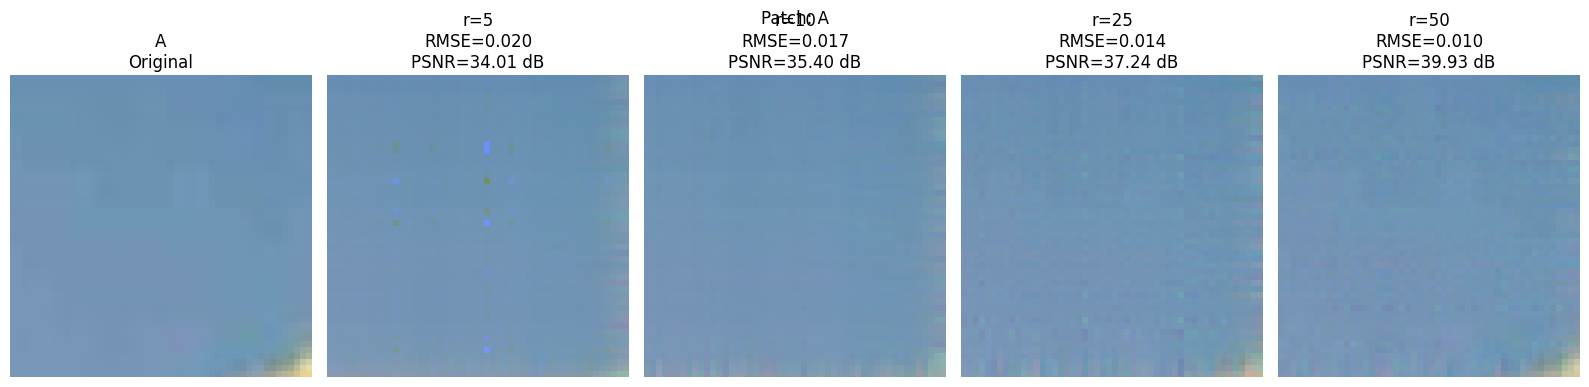

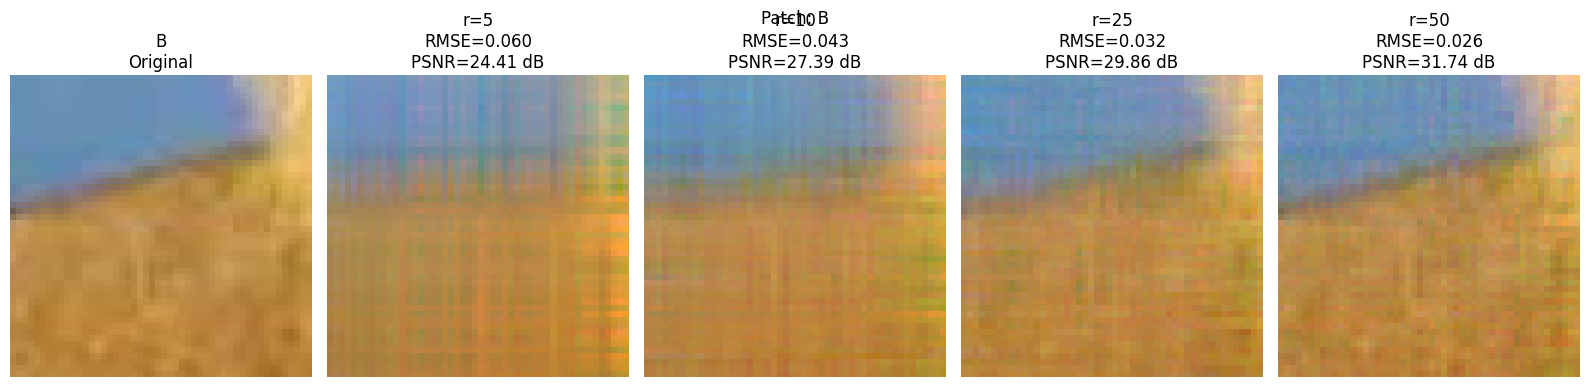

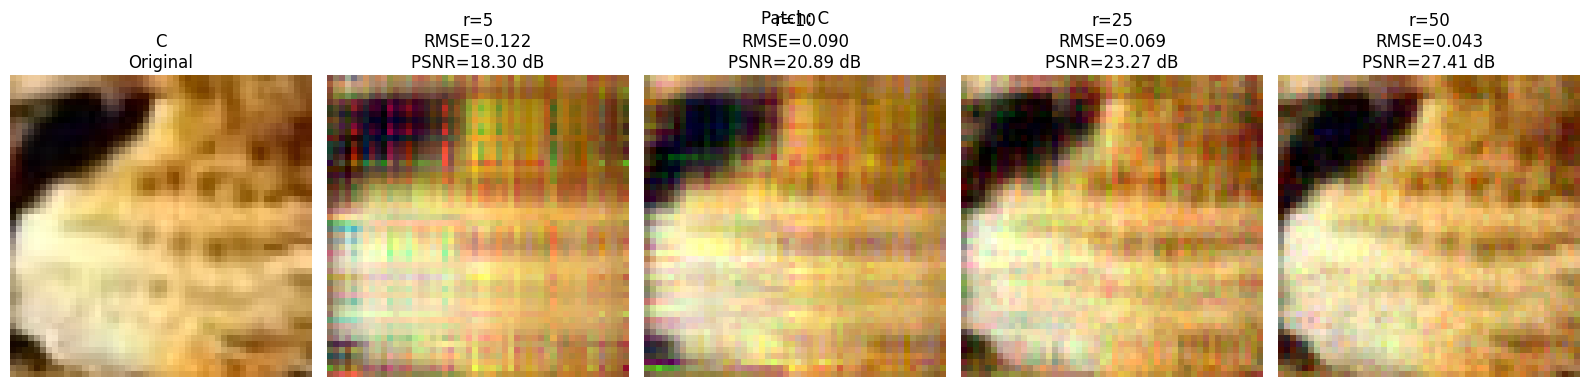

In [90]:
# Display results for each patch
for name, (top, left) in patch_coords.items():
    fig, axes = plt.subplots(1, len(r_values)+1, figsize=(16, 4))

    # Show original patch
    orig_patch = extract_patch(cropped_img, top, left, size)
    axes[0].imshow(orig_patch)
    axes[0].set_title(f"{name}\nOriginal")
    axes[0].axis('off')

    # Show reconstructions
    for i, r in enumerate(r_values):
        rm, ps, full_img = results[(name, r)]
        recon_patch = extract_patch(full_img, top, left, size)
        axes[i+1].imshow(recon_patch)
        axes[i+1].set_title(f"r={r}\nRMSE={rm:.3f}\nPSNR={ps:.2f} dB")
        axes[i+1].axis('off')

    plt.suptitle(f"Patch: {name}")
    plt.tight_layout()
    plt.show()

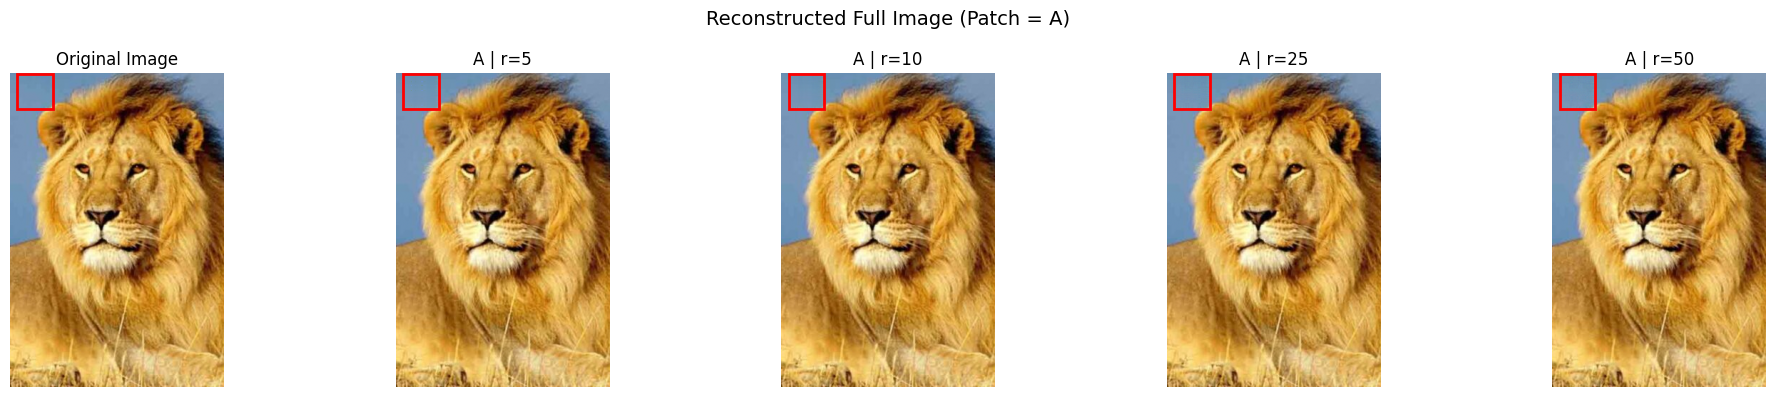

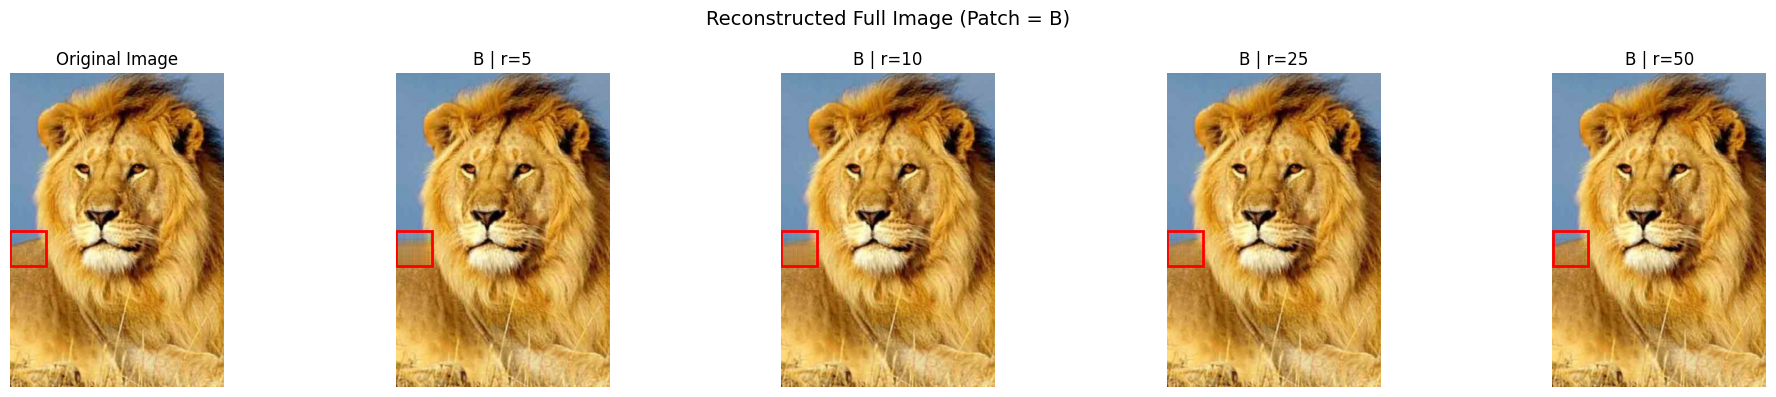

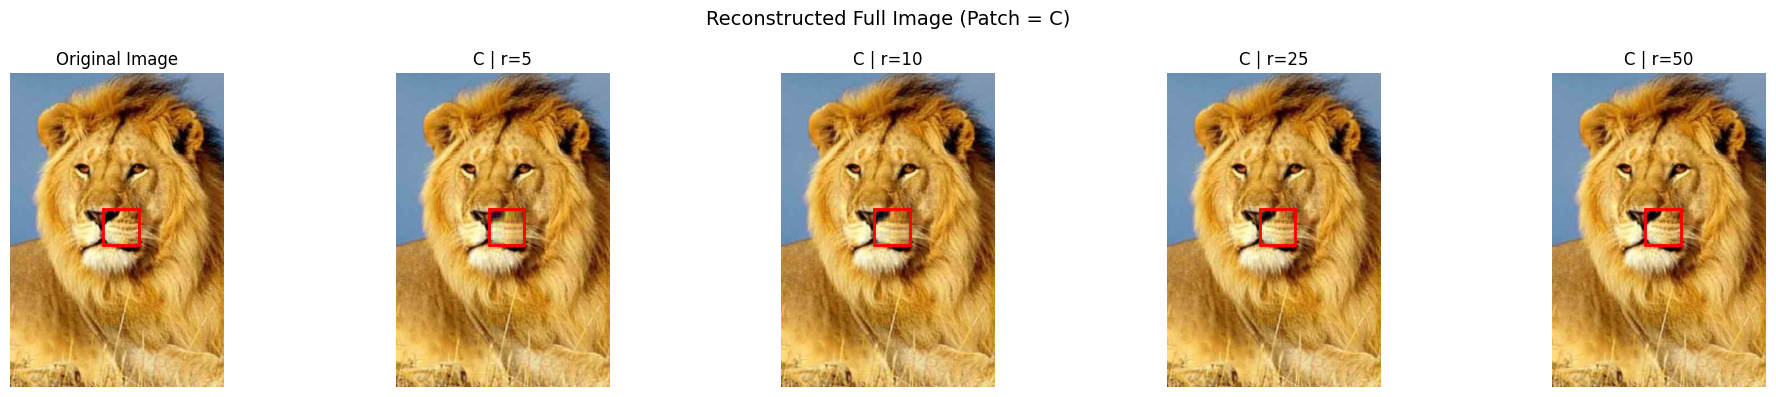

In [91]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

for name, (top, left) in patch_coords.items():
    fig, axes = plt.subplots(1, len(r_values) + 1, figsize=(20, 4))

    #Original Image
    axes[0].imshow(cropped_img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    #Highlight patches
    rect = patches.Rectangle(
        (left, top), size, size,
        linewidth=2, edgecolor='red', facecolor='none'
    )
    axes[0].add_patch(rect)

    # Reconstruction for each rank
    for i, r in enumerate(r_values):
        _, _, full_img = results[(name, r)]
        axes[i + 1].imshow(full_img)
        axes[i + 1].set_title(f"{name} | r={r}")
        axes[i + 1].axis("off")
        rect = patches.Rectangle(
            (left, top), size, size,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        axes[i + 1].add_patch(rect)

    plt.suptitle(f"Reconstructed Full Image (Patch = {name})", fontsize=14)
    plt.tight_layout()
    plt.show()